توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data


!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip

!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:

# function 1
def displacement(img):
    # Get the dimensions of the image
    height, width, channels = img.shape
    percentage = np.random.uniform(0.1, 0.3)
    x_shift = int(percentage * width)
    y_shift = int(percentage * height)
    # Create an empty canvas to hold the shifted image
    shifted_image = np.zeros_like(img)
    # change array indices to get the
    if x_shift >= 0 and y_shift >= 0:
        shifted_image[y_shift:, x_shift:] = img[:height-y_shift, :width-x_shift]
    elif x_shift >= 0 and y_shift < 0:
        shifted_image[:height+y_shift, x_shift:] = img[-y_shift:, :width-x_shift]
    elif x_shift < 0 and y_shift >= 0:
        shifted_image[y_shift:, :width+x_shift] = img[:height-y_shift, -x_shift:]
    elif x_shift < 0 and y_shift < 0:
        shifted_image[:height+y_shift, :width+x_shift] = img[-y_shift:, -x_shift:]
    return shifted_image[y_shift:, x_shift:]
#     return shifted_image


# function 2
def find_the_biggest_square(img):
    width, height = img.shape[:2]
    center = ( width//2 , height//2 )
    for i in range(10, center[0]) :
        if img[ center[0]-i , center[1]-i , 0 ] == 0 and img[ center[0]-i , center[1]-i , 1 ] == 0 and img[ center[0]-i , center[1]-i , 2 ] == 0  :
            break
        if img[ center[0]-i , center[1]+i , 0 ] == 0 and img[ center[0]-i , center[1]+i , 1] == 0 and img[ center[0]-i , center[1]+i , 2] == 0:
            break
        if img[ center[0]+i , center[1]-i , 0 ] == 0  and img[ center[0]+i , center[1]-i , 1] == 0 and img[ center[0]+i , center[1]-i , 2 ] == 0 :
            break
        if img[ center[0]+i , center[1]+i , 0 ] == 0 and img[ center[0]+i , center[1]+i , 1 ] == 0 and img[ center[0]+i , center[1]+i , 2 ] == 0:
            break

    cropped_image = img[ center[0]-i : center[0]+ i, center[1]-i : center[1]+ i ]
    return cropped_image , i


def rotation(img):
# Rotate image
    width, height = img.shape[:2]
    center = ( width//2 , height//2 )
    angle = np.random.choice(range(15,30))
    height, width = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
    rotated_image , idx = find_the_biggest_square(rotated_image)
    return rotated_image, img[ center[0]- idx : center[0]+ idx, center[1]-idx : center[1]+ idx ]

# function 3
def scaling(img):
    scale = np.random.uniform(1.1, 1.3)
    # Resize the image
    center = (img.shape[0]//2, img.shape[1]//2)
    height = int(img.shape[0] * scale)
    width = int(img.shape[1] * scale)
    scaled_image = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
    return scaled_image[height//2 - center[0]: height//2 + center[0] , width//2 - center[1]: width//2 + center[1] ]

# function 4
def Brightness(img, alpha=1.0, beta=0):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    adjusted_image = cv2.addWeighted(gray_image, alpha, gray_image, 1 - alpha, beta)
    if img.ndim == 3:
        adjusted_image = cv2.cvtColor(adjusted_image, cv2.COLOR_GRAY2BGR)

    return adjusted_image

# function 5
def bluring(img, kernel_size=(5, 5)):
    blurred_image = cv2.GaussianBlur(img, kernel_size, 0)
    return blurred_image

# function 6
def gaussian_noise(img, mean=0.0, stddev=25):
    gaussian_noise = np.random.normal(mean, stddev, img.shape).astype(np.uint8)
    noisy_image = cv2.add(img, gaussian_noise)
    return noisy_image


In [4]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
label_list = [0,1,2,3,4,5,6]

class CustomDataset(Dataset):
    def __init__(self, root_dir,start = 0, end = 2000,  transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)[start:end]
        self.change_functions = ['displacement', 'rotation', 'scaling']

    def generate_label(self, label = None):
        if not label and label != 0: 
            label = np.random.choice(label_list)
        if label == 0 : 
            transformations = {}
        if label == 1 : 
            transformations = {"displacement"}
        if label == 2 : 
            transformations = {"rotation"}
        if label == 3 : 
            transformations = {"scaling"}
        if label == 4 : 
            transformations = {"displacement" , "rotation"}
        if label == 5 : 
            transformations = {"displacement" , "scaling"}
        if label == 6 : 
            transformations = {"rotation" , "scaling"}   
        return transformations, label 
    def apply_changes(self, img_path) :
        # Read the image using OpenCV
        orginal_image = cv2.imread(os.path.join(self.root_dir, img_path))
        orginal_image = cv2.cvtColor(orginal_image, cv2.COLOR_BGR2RGB)
        transformations, label = self.generate_label()
        changed_image = np.copy(orginal_image)
        if 'rotation' in transformations :
            changed_image, orginal_image = rotation(changed_image)
        if 'displacement' in transformations :
            changed_image = displacement(changed_image)
        if 'scaling' in transformations :
            changed_image = scaling(changed_image)

        return orginal_image, changed_image, label

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_rgb, changed_image, label = self.apply_changes(img_path)
        img_rgb = Image.fromarray(img_rgb)
        changed_image = Image.fromarray(changed_image)
        if self.transform:
            img_rgb = self.transform(img_rgb)
            changed_image = self.transform(changed_image)
        return img_rgb, changed_image, label

    def __len__(self):
        return len(self.image_paths)


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# path to directories
train_dir = 'ADEChallengeData2016/images/training'
valid_dir = 'ADEChallengeData2016/images/validation'

dataset_train = CustomDataset(root_dir=train_dir,start = 0, end = 15000,  transform=transform)
dataset_val = CustomDataset(root_dir=train_dir,start = 15000, end = 20000, transform=transform)
dataset_test = CustomDataset(root_dir=valid_dir,start = 0, end = 4000,  transform=transform)




train_loader = DataLoader(dataset_train, batch_size=8 , shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8 , shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=8 , shuffle=True)



Training Datas
Train Data with transformation =  {}


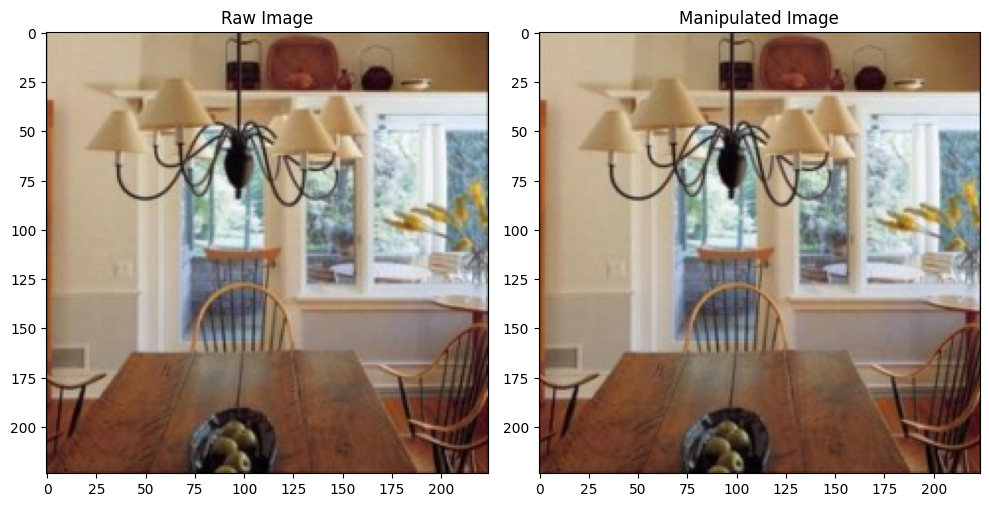

Train Data with transformation =  {'rotation'}


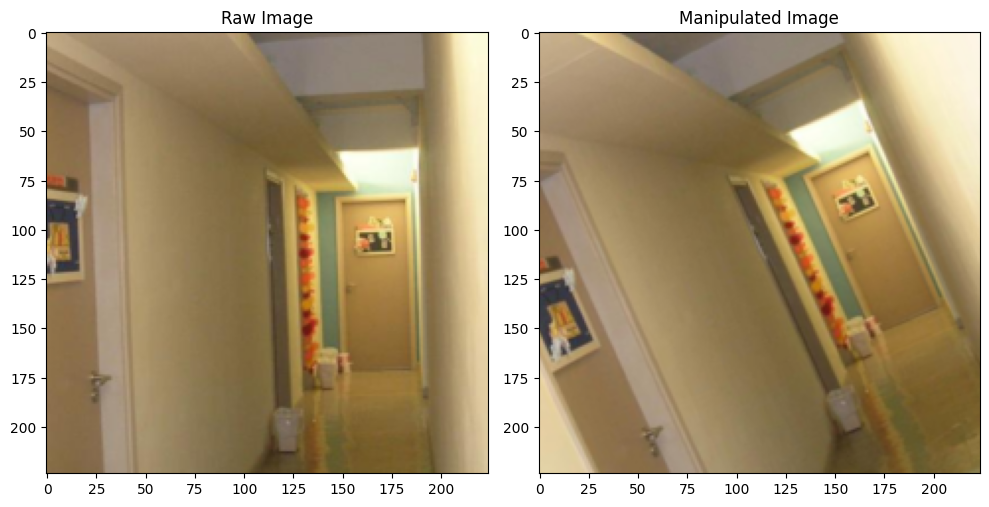

Train Data with transformation =  {'rotation', 'scaling'}


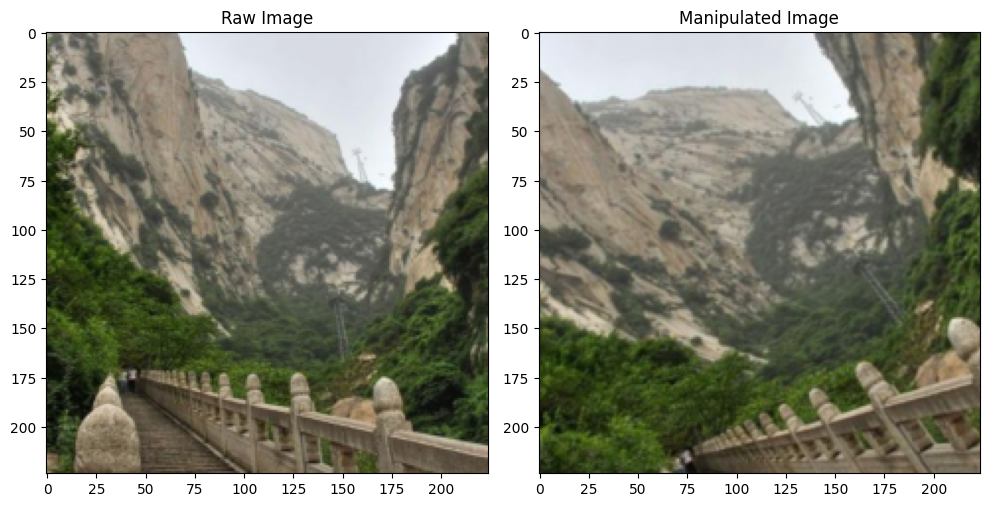

Train Data with transformation =  {'displacement', 'scaling'}


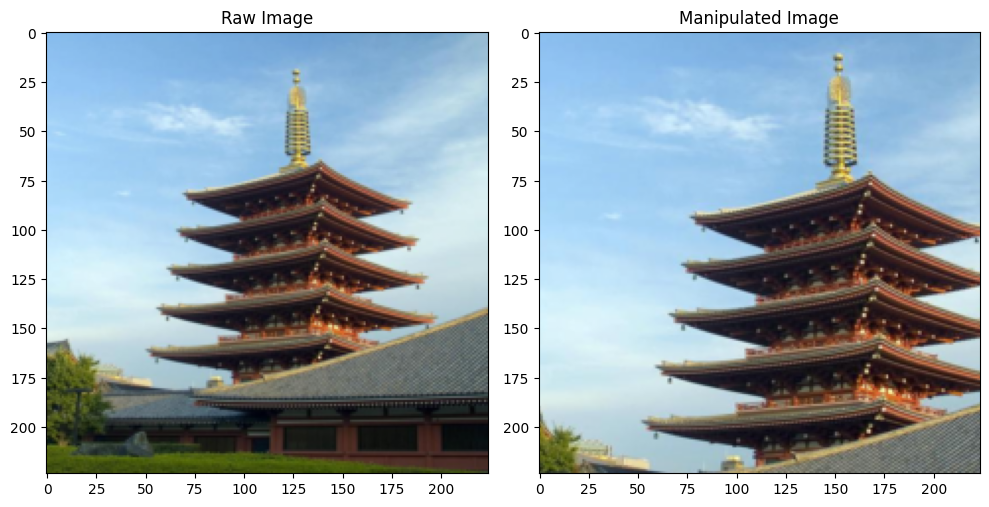

Train Data with transformation =  {'displacement', 'rotation'}


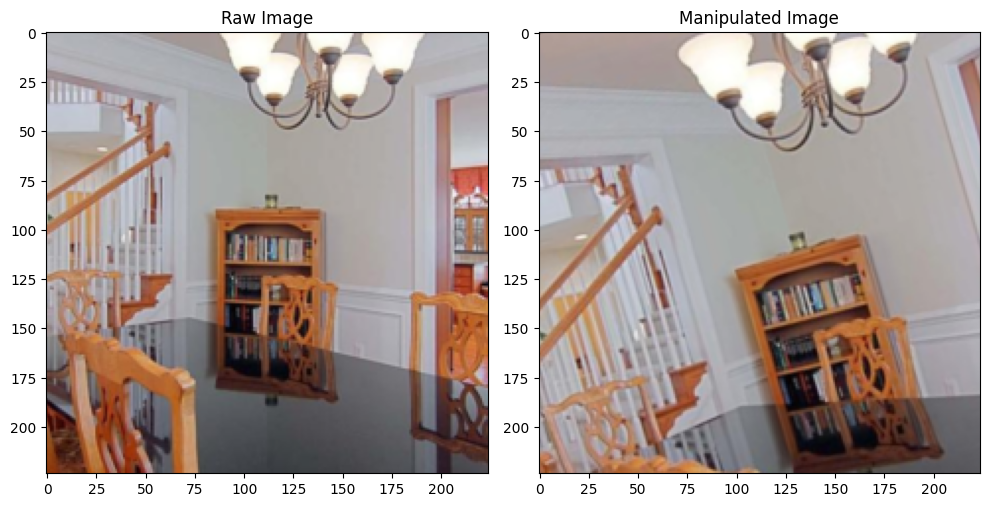

Train Data with transformation =  {'displacement'}


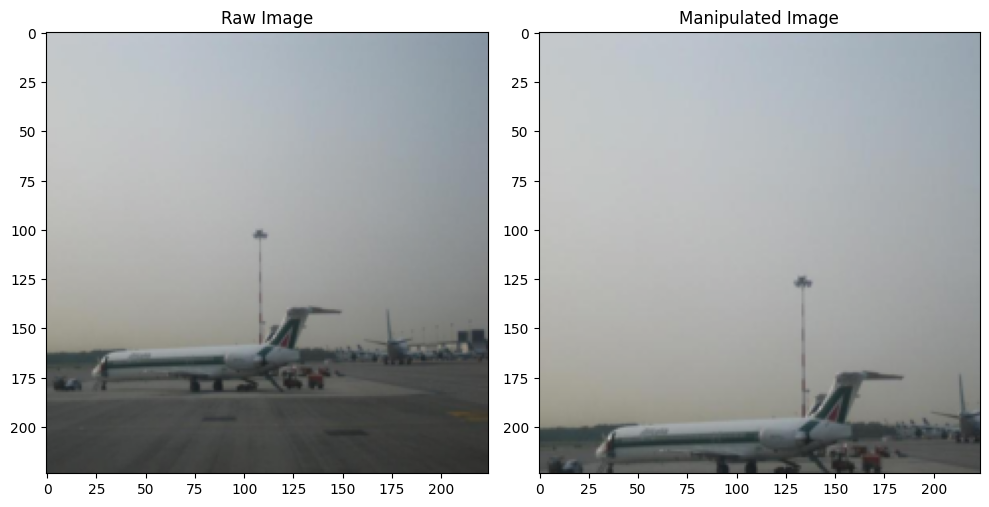

Train Data with transformation =  {'displacement', 'scaling'}


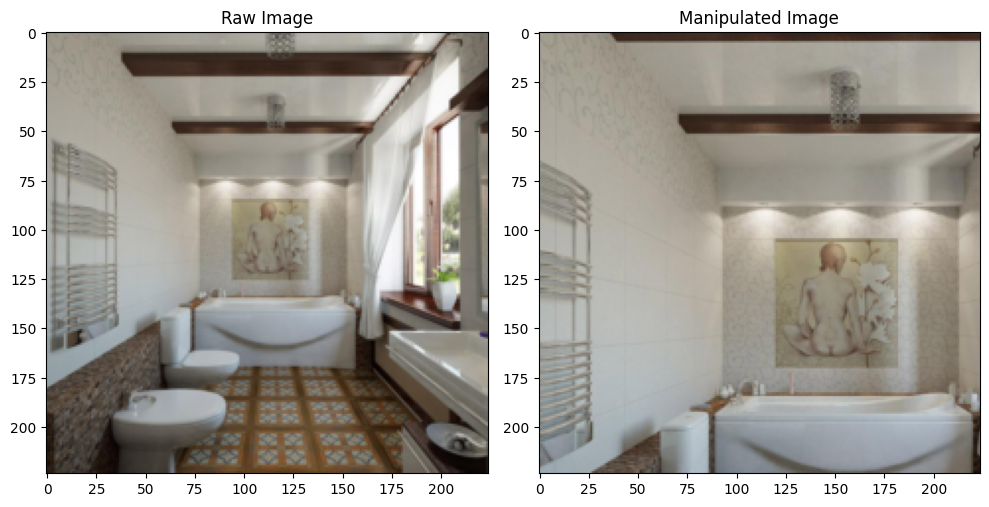

Train Data with transformation =  {'displacement', 'rotation'}


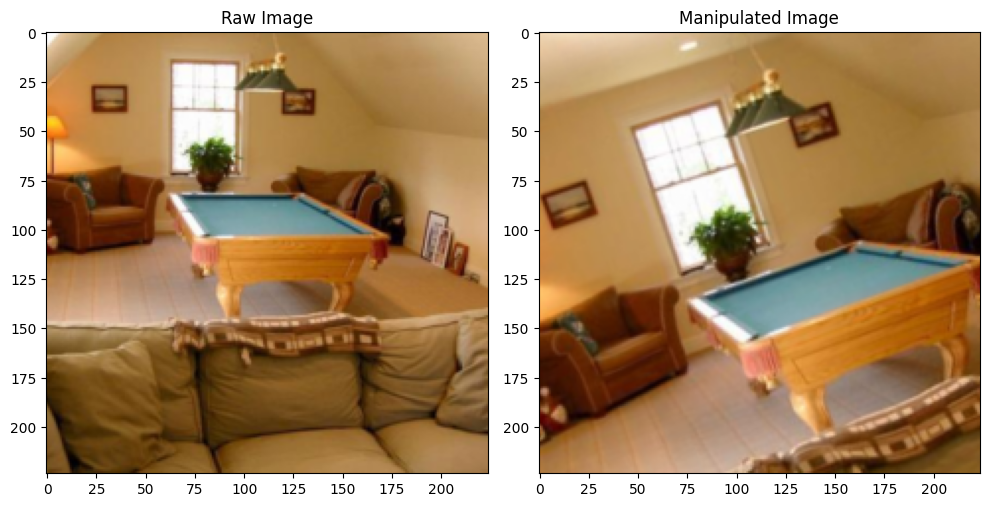

Test Datas
 Test Data with transformation  = {'rotation', 'scaling'} 


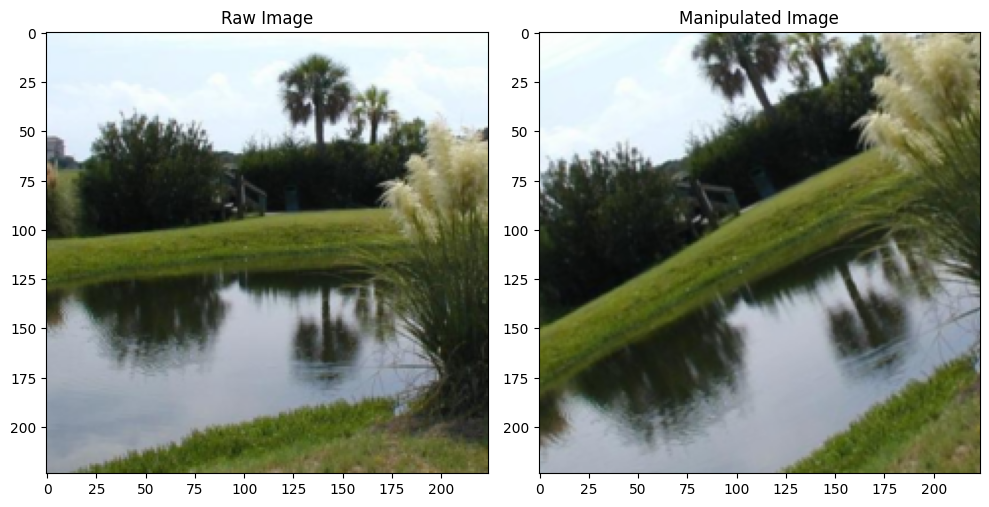

 Test Data with transformation  = {'displacement', 'rotation'} 


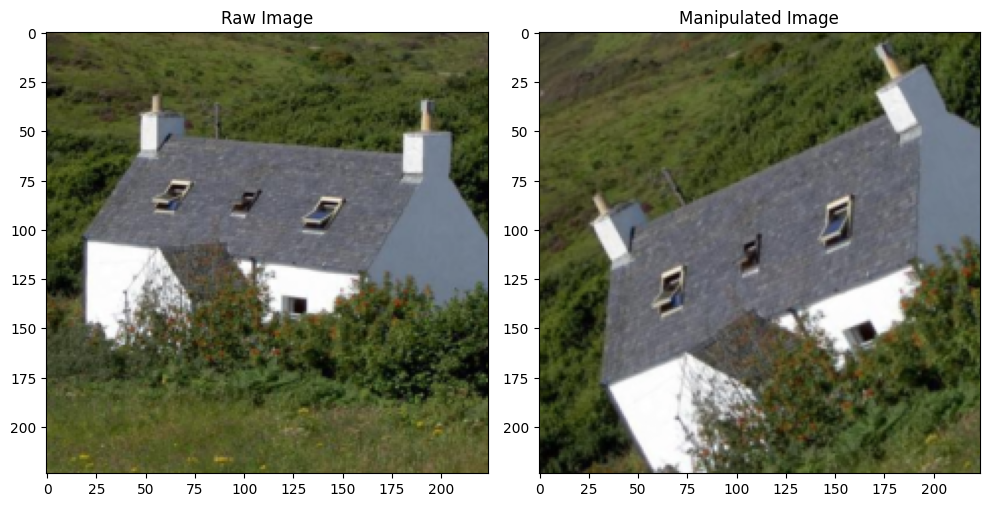

 Test Data with transformation  = {} 


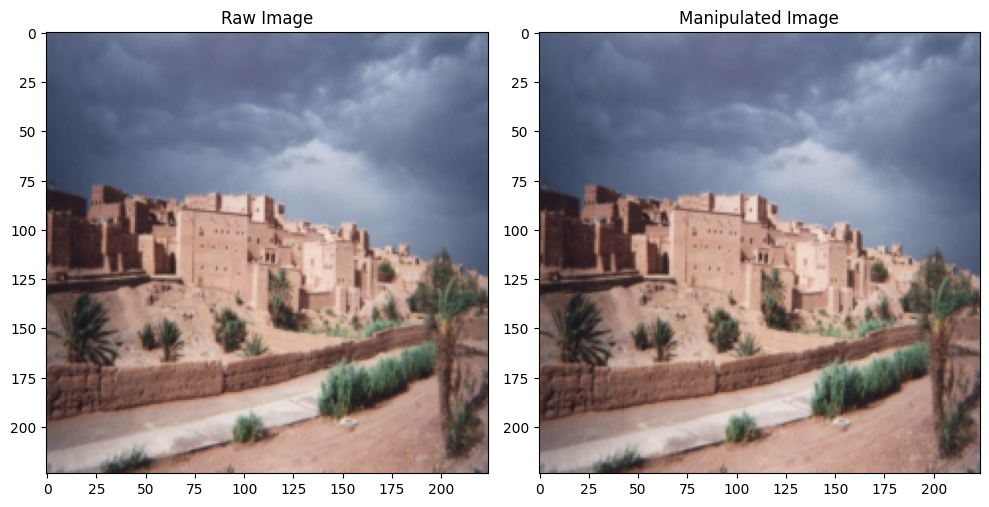

 Test Data with transformation  = {'displacement', 'rotation'} 


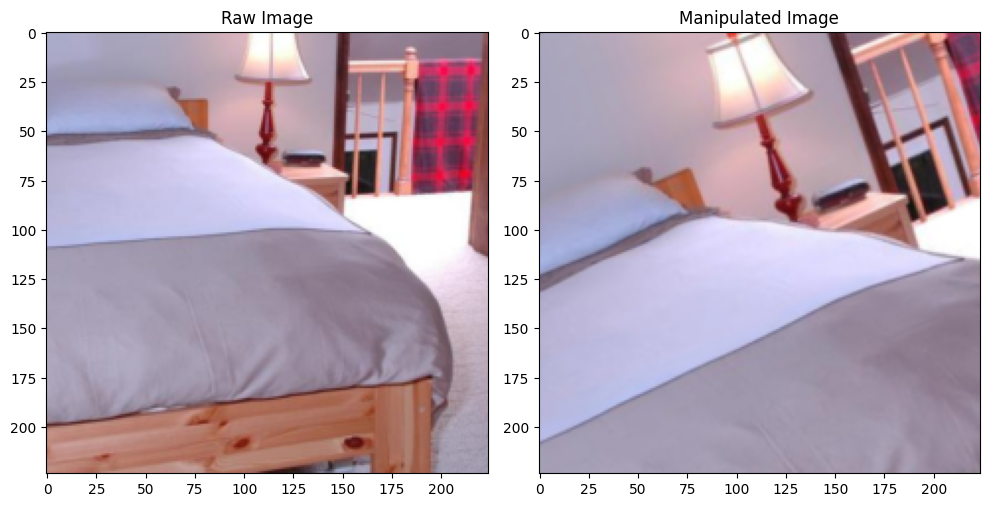

 Test Data with transformation  = {'scaling'} 


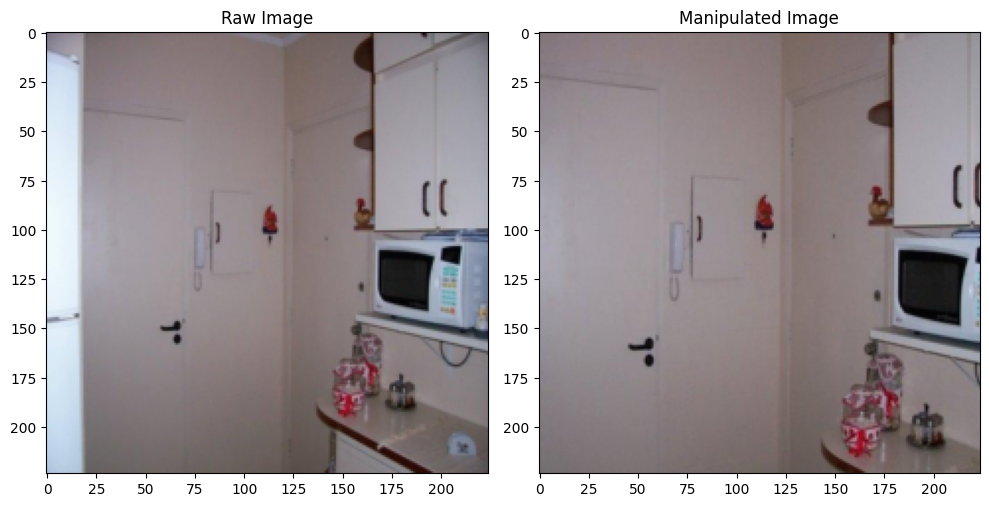

 Test Data with transformation  = {'displacement', 'rotation'} 


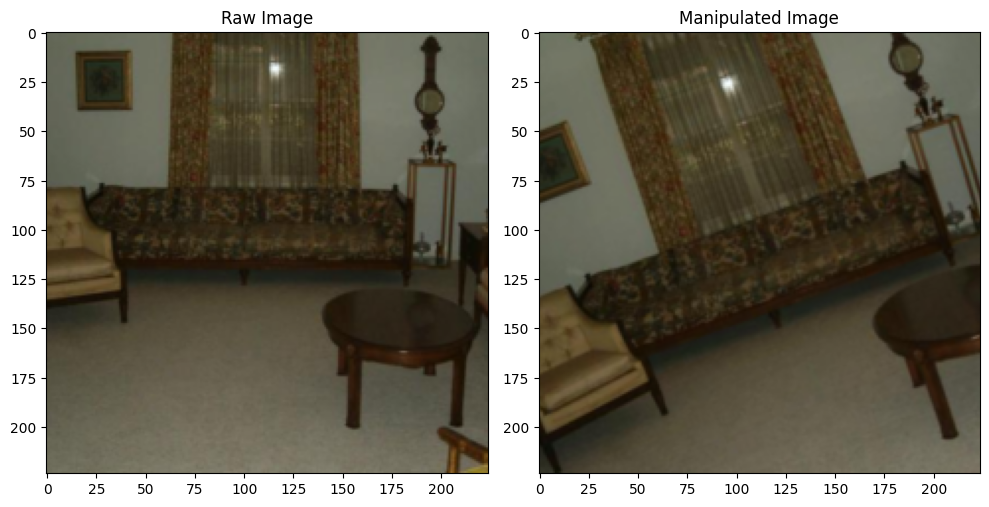

 Test Data with transformation  = {'displacement'} 


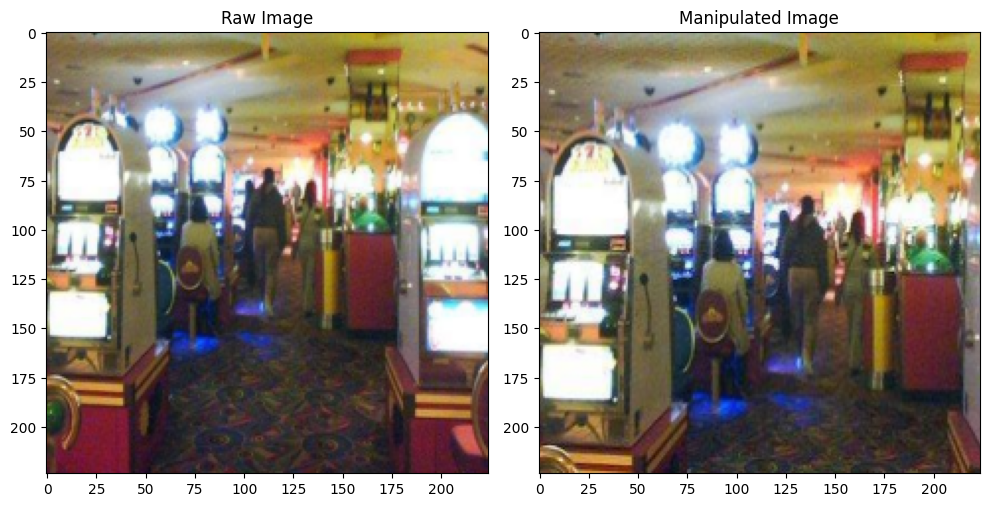

 Test Data with transformation  = {'scaling'} 


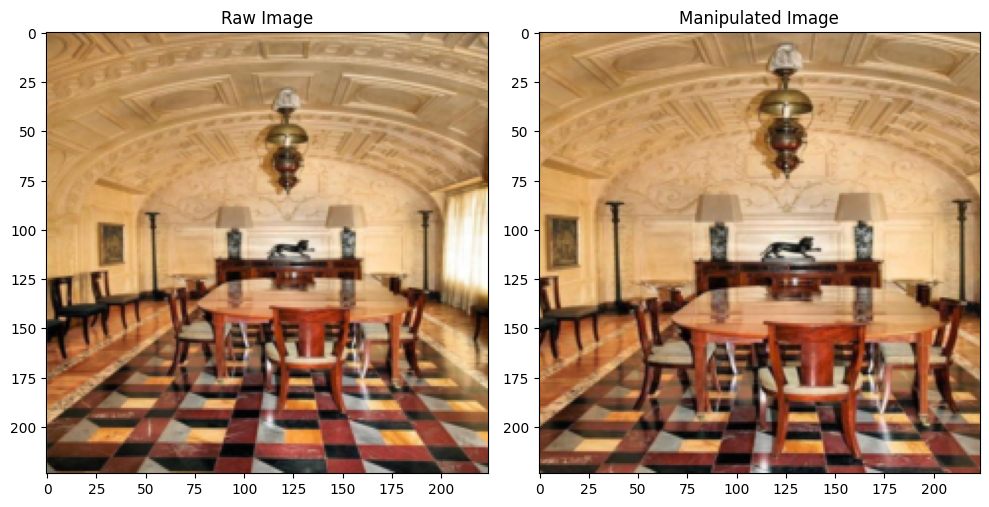

In [6]:
## show 8 images from train_loader & 8 images from test_loader
for original_images, changed_images, labels in train_loader:
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define the denormalization transform
    denormalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    original_images = denormalize(original_images)
    changed_images = denormalize(changed_images)
    print("Training Datas")
    for i in range(len(original_images)):

        print(f"Train Data with transformation =  {dataset_train.generate_label(labels[i])[0]}")
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

        axes[0].imshow(original_images[i].permute(1, 2, 0))
        axes[0].set_title('Raw Image')

        axes[1].imshow(changed_images[i].permute(1, 2, 0))
        axes[1].set_title('Manipulated Image')

        # Show the images
        plt.tight_layout()  
        plt.show()
    break

for original_images, changed_images, labels in test_loader:
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define the denormalization transform
    denormalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    original_images = denormalize(original_images)
    changed_images = denormalize(changed_images)
    
    print("Test Datas")
    for i in range(len(original_images)):

        print(f" Test Data with transformation  = {dataset_test.generate_label(labels[i])[0] } ")
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
        axes[0].imshow(original_images[i].permute(1, 2, 0))
        axes[0].set_title('Raw Image')
        axes[1].imshow(changed_images[i].permute(1, 2, 0))
        axes[1].set_title('Manipulated Image')

        # Show the images
        plt.tight_layout()
        plt.show()
    break



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

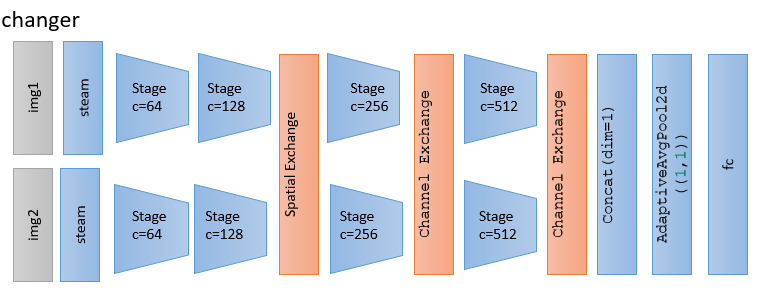

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


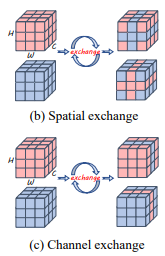

In [7]:
## dont change this block

from mmengine.model import BaseModule

class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """

    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

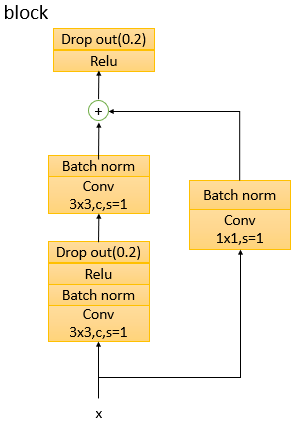

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





با توجه به این که دو مسیر با یکدیگر جمع می شوند باید تعداد کانال ها در مسیر سمت راست با تعداد کانال در 
مسیر سمت چپ برابر باشد به عبارتی چون خروجی بعد از جمع شوند تغییر کانال نمیدهد تعداد کانال های 
خروجی دقیقا باید برابر تعداد کانال خروجی بلاک ، استیج که در شکل اول قابل مشاهده است برداشت شود. 

پدینگ در این کانولوشن یک در یک طبیعتا باید صفر باشد چرا که در صورت انتخاب حاشیه اطلاعاتی از خود ورودی به دست نمی آید.


کانولوشن یک در یک برای یادگیری اطلاعات کانال و تغییر تعداد کانال به صورت قابل یادگیری استفاده می شود. 


In [8]:
class Block(nn.Module):
    def __init__(self, in_size, out_size):

        super(Block, self).__init__()

        ### first layer
        self.conv1 = nn.Conv2d(in_channels = in_size, out_channels = out_size  , kernel_size = 3 , stride = 1, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = out_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(in_channels = out_size , out_channels = out_size, kernel_size = 3 , stride =1 , padding = 1 )
        self.batchnorm2 = nn.BatchNorm2d(num_features = out_size)

        ### second layer
        self.conv3 = nn.Conv2d(in_channels = in_size, out_channels = out_size, kernel_size = 1 , stride = 1, padding = 0 )
        self.batchnorm3 = nn.BatchNorm2d(num_features = out_size)

    def forward(self, x):
        ### first layer
        out1 = self.conv1(x)
        out1 = self.batchnorm1(out1)
        out1 = self.relu(out1)
        out1 = self.dropout(out1)
        out1 = self.conv2(out1)
        out1 = self.batchnorm2(out1)

        ### second layer
        out2 = self.conv3(x)
        out2 = self.batchnorm3(out2)

        ## adds up the out put
        out = self.relu(out1 + out2)
        out = self.dropout(out)
        
        return out




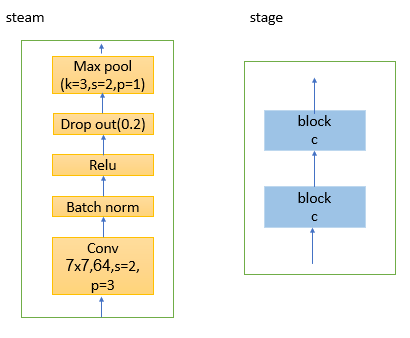

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [9]:
#To Do
class changer(nn.Module):
    def __init__(self, in_size = 3, out_size = 64):
        super(changer, self).__init__()
        self.steam = nn.Sequential(
            nn.Conv2d(in_channels = in_size , out_channels = out_size, kernel_size=7, stride = 2 , padding = 3),
            nn.BatchNorm2d(num_features = out_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )

        self.stage1 = self._make_stage( input_channels = out_size , output_channels = 64)
        self.stage2 = self._make_stage( input_channels = 64, output_channels = 128)
        self.stage3 = self._make_stage( input_channels = 128, output_channels = 256)
        self.stage4 = self._make_stage( input_channels= 256 , output_channels = 512)
        self.spatial_exchange = SpatialExchange()
        self.channel_exchange = ChannelExchange()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))


        # FC  Layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 , 512),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(512, len(label_list)),
            nn.Softmax()
            )

    def _make_stage(self,input_channels , output_channels):

        layers = [
              Block(in_size = input_channels, out_size = output_channels ),
              Block(in_size = output_channels  , out_size = output_channels)
        ]
        return nn.Sequential(*layers)


    def forward(self,x1,x2):
        x1 = self.steam(x1)
        x1 = self.stage1(x1)
        x1 = self.stage2(x1)

        x2 = self.steam(x2)
        x2 = self.stage1(x2)
        x2 = self.stage2(x2)

        x1, x2 = self.spatial_exchange(x1, x2)

        x1 = self.stage3(x1)
        x2 = self.stage3(x2)

        x1, x2 = self.channel_exchange(x1, x2)

        x1 = self.stage4(x1)
        x2 = self.stage4(x2)

        x1, x2 = self.channel_exchange(x1, x2)

        x = torch.cat([x1, x2], dim=1)
        x = self.avg_pool(x)
        out = self.fc(x)

        return out

In [10]:
import gc
torch.cuda.empty_cache()
# del model, org_image, changed_image, labels
gc.collect()

2927

In [11]:
## To Do
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=changer().to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for param in model.parameters():
    param.requires_grad = True

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)

# Apply Xavier initialization to the model parameters
initialize_weights(model)


Train & validation


In [156]:
# Assuming you have your model, criterion, and optimizer defined
train_loader = DataLoader(dataset_train, batch_size=24 , shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=24 , shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=24 , shuffle=True)

num_epochs = 20  # Define the number of epochs
train_losses = []  # List to store training losses
valid_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    Sum_loss = 0.0
    num_correct_train = 0

    for batch_idx, (org_image, changed_image, labels) in enumerate(train_loader):
        # Move data to GPU if available
        org_image, changed_image, labels = org_image.to(device), changed_image.to(device), labels.to(torch.long).to(device)
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(org_image, changed_image)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(outputs, dim=1) 
        correct = (predicted == labels.int()).int()
        num_correct_train += correct.sum().item()

        Sum_loss += loss.item()

        if batch_idx%80 == 0 :
            print(f"mini Batch Loss is {loss.item():.3f} ")

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = Sum_loss / len(train_loader)
    accuracy_train = num_correct_train / len(train_loader.dataset)

    train_losses.append(epoch_loss)  # Save training loss

    # Validation
    
    model.eval()  # evaluation mode
    loss_val = 0.0 # initilize validation loss
    num_correct_val = 0 

    with torch.no_grad():
        for batch_idx, (org_image, changed_image, labels) in enumerate(val_loader):
            ### locate the variables to device 
            org_image, changed_image, labels = org_image.to(device), changed_image.to(device), labels.to(torch.long).to(device)

            ### forward 
            outputs = model(org_image, changed_image)
            ### calculate validation loss for mini batch
            loss = criterion(outputs, labels)
            ### classify the out put based on Probability 
            predicted = torch.argmax(outputs, dim=1) 
            ### calculate the correct calssification
            correct = (predicted == labels.int()).int()
            ### save the numbers of correct Decisions in mini batch
            num_correct_val += correct.sum().item()
            ### save the loss in mini batch
            loss_val += loss.item()
            
    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = loss_val / len(val_loader)
    accuracy_val = num_correct_val / len(val_loader.dataset)

    valid_losses.append(epoch_val_loss)  # Save validation loss

    # Print and log the losses and accuracies for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"AVG_Epoch_Loss_TRAIN = {epoch_loss:.3f},\n acc_train = {accuracy_train:.3f}, \n"
          f"AVG_Epoch_Loss_Val = {epoch_val_loss:.3f},\n acc_val = {accuracy_val:.3f}")
    
    print (f"Sum_loss_TRAIN ={Sum_loss:.3f},\n num_correct_train={(num_correct_train)},\n Sum_loss_VAL= {loss_val:.3f},\n num_correct_val={(num_correct_val)}")

mini Batch Loss is 1.722 
mini Batch Loss is 1.641 
mini Batch Loss is 1.422 
Epoch [1/20] AVG_Epoch_Loss_TRAIN = 1.535,
 acc_train = 0.629, 
AVG_Epoch_Loss_Val = 1.572,
 acc_val = 0.582
Sum_loss_TRAIN =320.844,
 num_correct_train=3144,
 Sum_loss_VAL= 33.008,
 num_correct_val=291
mini Batch Loss is 1.503 
mini Batch Loss is 1.575 
mini Batch Loss is 1.508 
Epoch [2/20] AVG_Epoch_Loss_TRAIN = 1.492,
 acc_train = 0.670, 
AVG_Epoch_Loss_Val = 1.508,
 acc_val = 0.654
Sum_loss_TRAIN =311.845,
 num_correct_train=3350,
 Sum_loss_VAL= 31.676,
 num_correct_val=327
mini Batch Loss is 1.395 
mini Batch Loss is 1.366 
mini Batch Loss is 1.443 
Epoch [3/20] AVG_Epoch_Loss_TRAIN = 1.467,
 acc_train = 0.703, 
AVG_Epoch_Loss_Val = 1.441,
 acc_val = 0.724
Sum_loss_TRAIN =306.684,
 num_correct_train=3513,
 Sum_loss_VAL= 30.260,
 num_correct_val=362
mini Batch Loss is 1.391 
mini Batch Loss is 1.442 
mini Batch Loss is 1.521 
Epoch [4/20] AVG_Epoch_Loss_TRAIN = 1.454,
 acc_train = 0.713, 
AVG_Epoch_Loss_

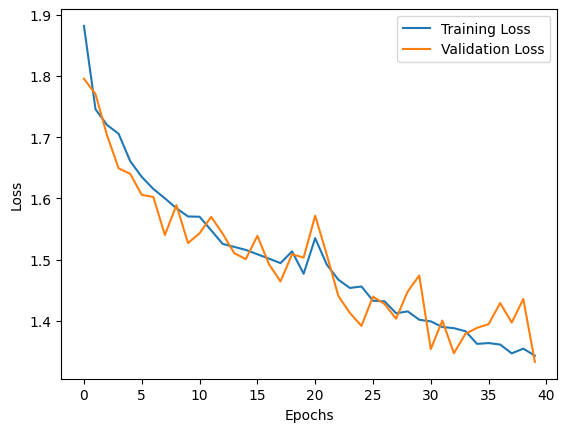

In [160]:
# Plotting the losses
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), 'my_model.pth')

In [12]:
# Load the saved weights into the model
### pass to my model 
weights_file_name = '/kaggle/input/mymodel/my_model.pth' 
model = changer().to(device)
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.load_state_dict(torch.load(weights_file_name))

<All keys matched successfully>

Due to GPU RAM limitation problem I trained my model multiple time here is the last 20 epochs to achieve better result.

In [15]:
# Assuming you have your model, criterion, and optimizer defined
train_loader = DataLoader(dataset_train, batch_size=32 , shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32 , shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32 , shuffle=True)

num_epochs = 20  # Define the number of epochs
train_losses = []  # List to store training losses
valid_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    Sum_loss = 0.0
    num_correct_train = 0

    for batch_idx, (org_image, changed_image, labels) in enumerate(train_loader):
        # Move data to GPU if available
        org_image, changed_image, labels = org_image.to(device), changed_image.to(device), labels.to(torch.long).to(device)
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(org_image, changed_image)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(outputs, dim=1) 
        correct = (predicted == labels.int()).int()
        num_correct_train += correct.sum().item()

        Sum_loss += loss.item()

        if batch_idx%80 == 0 :
            print(f"mini Batch Loss is {loss.item():.3f} ")

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = Sum_loss / len(train_loader)
    accuracy_train = num_correct_train / len(train_loader.dataset)

    train_losses.append(epoch_loss)  # Save training loss

    # Validation
    
    model.eval()  # evaluation mode
    loss_val = 0.0 # initilize validation loss
    num_correct_val = 0 

    with torch.no_grad():
        for batch_idx, (org_image, changed_image, labels) in enumerate(val_loader):
            ### locate the variables to device 
            org_image, changed_image, labels = org_image.to(device), changed_image.to(device), labels.to(torch.long).to(device)

            ### forward 
            outputs = model(org_image, changed_image)
            ### calculate validation loss for mini batch
            loss = criterion(outputs, labels)
            ### classify the out put based on Probability 
            predicted = torch.argmax(outputs, dim=1) 
            ### calculate the correct calssification
            correct = (predicted == labels.int()).int()
            ### save the numbers of correct Decisions in mini batch
            num_correct_val += correct.sum().item()
            ### save the loss in mini batch
            loss_val += loss.item()
            
    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = loss_val / len(val_loader)
    accuracy_val = num_correct_val / len(val_loader.dataset)

    valid_losses.append(epoch_val_loss)  # Save validation loss

    # Print and log the losses and accuracies for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"AVG_Epoch_Loss_TRAIN = {epoch_loss:.3f},\n acc_train = {accuracy_train:.3f}, \n"
          f"AVG_Epoch_Loss_Val = {epoch_val_loss:.3f},\n acc_val = {accuracy_val:.3f}")
    
    print (f"Sum_loss_TRAIN ={Sum_loss:.3f},\n num_correct_train={(num_correct_train)},\n Sum_loss_VAL= {loss_val:.3f},\n num_correct_val={(num_correct_val)}")

mini Batch Loss is 1.295 
mini Batch Loss is 1.316 
mini Batch Loss is 1.262 
mini Batch Loss is 1.283 
mini Batch Loss is 1.315 
mini Batch Loss is 1.223 
Epoch [1/20] AVG_Epoch_Loss_TRAIN = 1.264,
 acc_train = 0.902, 
AVG_Epoch_Loss_Val = 1.322,
 acc_val = 0.845
Sum_loss_TRAIN =592.831,
 num_correct_train=13526,
 Sum_loss_VAL= 207.512,
 num_correct_val=4223
mini Batch Loss is 1.197 
mini Batch Loss is 1.252 
mini Batch Loss is 1.235 
mini Batch Loss is 1.219 
mini Batch Loss is 1.199 
mini Batch Loss is 1.303 
Epoch [2/20] AVG_Epoch_Loss_TRAIN = 1.261,
 acc_train = 0.906, 
AVG_Epoch_Loss_Val = 1.290,
 acc_val = 0.874
Sum_loss_TRAIN =591.540,
 num_correct_train=13594,
 Sum_loss_VAL= 202.495,
 num_correct_val=4371
mini Batch Loss is 1.226 
mini Batch Loss is 1.227 
mini Batch Loss is 1.209 
mini Batch Loss is 1.233 
mini Batch Loss is 1.197 
mini Batch Loss is 1.209 
Epoch [3/20] AVG_Epoch_Loss_TRAIN = 1.258,
 acc_train = 0.909, 
AVG_Epoch_Loss_Val = 1.287,
 acc_val = 0.878
Sum_loss_TR

#Test


In [21]:
# checkpoint = torch.load('my_model1.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']



# test
model.eval()  # evaluation mode
loss_test = 0.0 # initilize test loss
num_correct_test = 0 
### save labels and predicted values and labels for confusion matrix 
predicted_values = []
labels_values = []
with torch.no_grad():
    for batch_idx, (org_image, changed_image, labels) in enumerate(test_loader):
        ### locate the variables to device 
        org_image, changed_image, labels = org_image.to(device), changed_image.to(device), labels.to(torch.long).to(device)

        ### forward 
        outputs = model(org_image, changed_image)
        ### calculate validation loss for mini batch
        loss = criterion(outputs, labels)
        ### classify the out put based on Probability 
        predicted = torch.argmax(outputs, dim=1) 
        predicted_values += list(predicted)
        labels_values += list(labels)
        ### calculate the correct calssification
        correct = (predicted == labels.int()).int()
        ### save the numbers of correct Decisions in mini batch
        num_correct_test += correct.sum().item()
        ### save the loss in mini batch
        loss_test += loss.item()
            
# Calculate average validation loss and accuracy for the epoch
avg_test_loss = loss_test / len(test_loader)
accuracy_test = num_correct_test / len(test_loader.dataset)

print(f'loss_test = {loss_test:.3f},AVG loss_test = {avg_test_loss: .3f} acc_test={(accuracy_test)}')


loss_test = 81.739,AVG loss_test =  1.297 acc_test=0.8695


In [22]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(torch.stack(labels_values).cpu(), torch.stack(predicted_values).cpu())
print("Confusion Matrix:")
print(conf_matrix)
for label in range(7): 
    if label == 0 : 
        print(f"label {label} corresponds to transformations = empty " ) 
    if label == 1 : 
        print(f"label {label} corresponds to transformations = displacement " )
    if label == 2 : 
        print(f"label {label} corresponds to transformations = rotation " ) 
    if label == 3 : 
        print(f"label {label} corresponds to transformations = scaling " ) 
    if label == 4 : 
        print(f"label {label}  corresponds to transformations = displacement , rotation " ) 
    if label == 5 : 
        print(f"label {label} corresponds to transformations = displacement , scaling " ) 
    if label == 6 : 
        print(f"label {label} corresponds to transformations = rotation , scaling " ) 

Confusion Matrix:
[[261   0   0   0   0   0   0]
 [  0 267   0   0   0  13   0]
 [  0   3 257  16   4  10  23]
 [  1   3   0 283   0   2   0]
 [  0   0   4   0 220  51   0]
 [  0  16   0   2   2 271   0]
 [  0   0  27  20  17  47 180]]
label 0 corresponds to transformations = empty 
label 1 corresponds to transformations = displacement 
label 2 corresponds to transformations = rotation 
label 3 corresponds to transformations = scaling 
label 4  corresponds to transformations = displacement , rotation 
label 5 corresponds to transformations = displacement , scaling 
label 6 corresponds to transformations = rotation , scaling 


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

با توجه به کانفیوجن ماتریس بالا مدل به طور کلی به ترتیب برای کلاس های بدون تغییر و کلاس های با یک تغییر و دو تغییر بهترین عملکرد را داراست.  